In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Activation, Dropout,
                                     Conv2D, MaxPooling2D, Flatten)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import mse
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
height, width = 128, 128

[(9, 42, 23, 28, 28), (1, 20, 89, 28, 28)]


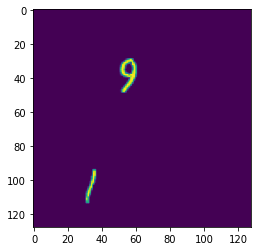

In [4]:
def make_img(x_array, y_array, height, width):
  new_img = np.zeros([height, width])
  mask = np.zeros([height, width])
  old_height = x_array.shape[1]
  old_width = x_array.shape[2]
  all_num = 2
  num = 0
  shifts = []
  while num < all_num:
    x_shift = random.randint(0, width-old_width)
    y_shift = random.randint(0, width-old_height)
    idx = random.randint(0, x_array.shape[0]-1)
    if (mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height]==0).all():
      new_img[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = x_array[idx]
      mask[y_shift: y_shift+old_height, x_shift: x_shift+old_height] = 1
      shifts.append((y_array[idx], x_shift, y_shift, 28, 28))
      num +=1
  return new_img, shifts

s = make_img(x_train, y_train, height, width)
plt.imshow(s[0])
print(s[1])
#plt.gca().add_patch(matplotlib.patches.Rectangle((s[2][0]),28,28, ec='r', fc='none'))

In [5]:
imgs = []
labels = []
for i in tqdm(range(40000)):
  sample = make_img(x_train, y_train, height, width)
  imgs.append(sample[0])
  labels.append(sample[1])

100%|██████████| 40000/40000 [00:05<00:00, 7784.66it/s]


In [6]:
labels[0]

[(2, 63, 15, 28, 28), (5, 77, 49, 28, 28)]

In [7]:
imgs = np.array(imgs)
imgs = imgs.reshape(-1, 128, 128, 1)
labels = np.array(labels)
print(imgs.shape)
print(labels.shape)

(40000, 128, 128, 1)
(40000, 2, 5)


In [8]:
#the sample is a square
#test parameters

#height, width = 128, 128
stride = 10
size = 28
padding = 4
n_rows = 10
n_cols = 10

dist_threshold = 20

#formula to big padding
big_padding = int((((size+2*padding)+stride*n_rows)-height)/2)

print("sample size with padding: ", height+2*big_padding)
print("box size with padding: ", size+2*padding)
print("stride: ", stride)
print("number of iteration in rows/cols: ", n_rows)

sample size with padding:  136
box size with padding:  36
stride:  10
number of iteration in rows/cols:  10


In [9]:
from math import sqrt

def kardashian_dist(labels, h, w):
    # 1. get coords
    # 2. count distance
    # 3. return smallest distance
    distances = []
    # example labels:
    # [(3, 22, 31, 28, 28), (9, 81, 46, 28, 28)]
    for i, label in enumerate(labels):
        x = label[1]
        y = label[2]
        # a^2 + b^2 = c^2
        # c = sqrt(a^2 + b^2)
        distance = sqrt((h - y)**2 + (w - x)**2)
        distances.append((i, distance))
    distances.sort(key=lambda x: x[1])

    return distances[0]

In [10]:
def  random_labels():
    #(0, 66, 81, 28, 28)
    return (random.randint(0,9), random.randint(size/2, height-size/2),
            random.randint(size/2, width-size/2), 28, 28)

In [11]:
random_labels()


(9, 78, 14, 28, 28)

In [109]:
opt = Adam()


In [110]:
def step(X, y):
    for row in range(n_rows):
        for col in range(n_cols):
            # x and y of the middle of our slice
            ybox = (size+2*padding)/2+stride*row
            xbox = (size+2*padding)/2+stride*col

            distance = kardashian_dist(y, ybox, xbox)
            sliced_X = X[row*stride: row*stride+36, col*stride: col*stride+36, :]
            
            plt.imshow(sliced_X.reshape(36,36))
            print(f"Sliced image shape: {sliced_X.shape}")

            if dist_threshold >= distance[1]:
                flag = np.array([1,0]).reshape(1,2)
                label = y[distance[0]]

            else:
                flag = np.array([0,1]).reshape(1,2)
                label = random_labels()

            with tf.GradientTape() as tape:
                pred = model(sliced_X.reshape(1, 36, 36, 1))
                confidence_loss = binary_crossentropy(flag, pred[1])
                print(f"pred[1][0]: {pred[1]}")
                if pred[1][0][0] >= 0.5:
                    clfs_loss = sparse_categorical_crossentropy(label[0], pred[0])
                    mse_loss = mse(label[1:], pred[2])
                    grads = tape.gradient([clfs_loss, confidence_loss, mse_loss], model.trainable_variables)
                    opt.apply_gradients(zip(grads, model.trainable_variables))
                else:
                    grads = tape.gradient(confidence_loss, model.trainable_variables)
                    opt.apply_gradients(zip(grads, model.trainable_variables))  

                #grads = tape.gradient(loss, model.trainable_variables)
                #opt.apply_gradients(zip(grads, model.trainable_variables))

(128, 128, 1) (2, 5)
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.5 0.5]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.49949998 0.50049996]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.499 0.501]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.49850005 0.50149995]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.8757707  0.12422932]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.10940118 0.8905988 ]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[1.0000000e+00 2.6797299e-11]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[1.000000e+00 1.300355e-09]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[9.9964535e-01 3.5467042e-04]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.50078535 0.4992147 ]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.50223917 0.49776074]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.5043724  0.49562752]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.507223   0.49277705]]
Sliced image shape: (36, 36, 1)
pred[1][0]: [[0.5106865  0.48931348]]
Sliced 

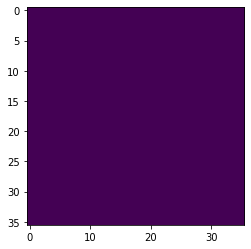

In [111]:
for x,y in zip(imgs, labels):
    print(x.shape, y.shape)
    step(x,y)
    break

In [86]:
model(x.reshape(1,36,36,1))


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[2.2385341e-22, 7.0252197e-20, 6.3458164e-19, 4.6856326e-07,
        2.5153026e-02, 1.7005808e-04, 9.7467643e-01, 5.1120027e-17,
        5.0417019e-17, 5.8615501e-22]], dtype=float32)>

In [49]:
# binary_crossentropy(flag, pred[1])

In [84]:
X_clfs = tf.random.uniform(shape=(1, 36, 36, 1))
for layer in model.layers[:]:
    X_clfs = layer(X_clfs)
    print(layer.__class__.__name__, 'output shape:\t', X_clfs.shape)

InputLayer output shape:	 (1, 36, 36, 1)
Conv2D output shape:	 (1, 36, 36, 16)
MaxPooling2D output shape:	 (1, 18, 18, 16)
Conv2D output shape:	 (1, 18, 18, 32)
MaxPooling2D output shape:	 (1, 9, 9, 32)
Conv2D output shape:	 (1, 9, 9, 64)
MaxPooling2D output shape:	 (1, 4, 4, 64)
Conv2D output shape:	 (1, 4, 4, 128)
MaxPooling2D output shape:	 (1, 2, 2, 128)
Flatten output shape:	 (1, 512)
Dense output shape:	 (1, 128)
Dense output shape:	 (1, 10)


In [48]:
X_conf = tf.random.uniform(shape=(1, 128))
layer = model.get_layer("conf")
X_conf = layer(X_conf)
print(layer.__class__.__name__, 'output shape:\t', X_conf.shape)

Dense output shape:	 (1, 2)


In [38]:
imgs[0].shape

(128, 128, 1)

#kiedy jest cyfra
    cyfry powinny być posortowane
    jeśli współrzędne są w kwadracie dodaj właściwy label
    predykcja confidence
    strata dla regresji powinna być mała
    klasyfikacja


#kiedy nie ma cyfry
    współrzędne nie są w kwadracie dodaj random label
    predykcja confidence
    nie liczymy straty regresji i klasyfikacji

In [96]:
inp = Input([36,36,1])
x = Conv2D(16, 3, padding='same', activation='relu')(inp)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu')(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128, activation='relu', name="dense1")(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu', name="dense2")(x)
# x = Dropout(0.4)(x)
clfs = Dense(10, activation="softmax", name="clfs")(x)
confidence = Dense(2, activation="softmax", name="conf")(x)
reg = Dense(4, activation="linear", name="reg")(x)

model = Model(inputs=inp, outputs=[clfs, confidence, reg])



In [56]:
inp = Input([36,36,1])
x = Conv2D(16, (3,3), padding="same", activation="relu")(inp)
x = MaxPooling2D()(x)

x = Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
clfs = Dense(10, activation="softmax")(x)
model = Model(inputs=inp, outputs=clfs)

In [57]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 36, 36, 1)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 36, 36, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 18, 18, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 18, 18, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 4, 4, 64)          0   

In [ ]:
model.compile(optimizer='adam',
              loss=[SparseCategoricalCrossentropy(from_logits=True),
                                      "binary_crossentropy",
                                      'mse'])

In [ ]:
model.summary()

In [ ]:
#model.fit(imgs, labels, epochs=5, batch_size=64)

In [ ]:
model.predict(imgs[1].reshape(1,96,96,1))

In [ ]:
labels[1]